# Optimization with PyMoosh

Many physical and engineering problems require an optimization phase, in order to find an object or a structure that best fits a given constraint or objective.

To this end, the first step is to define the objective the structure must meet or approach. This can be as simple as  maximising or minimising a specific parameter (e.g. reflectivity or transmissivity at a given wavelength), or as complex as angularly separating polarizations or maximizing the amount of energy absorbed in a specific layer of the material.

In any case, this definition needs to be written as an **objective function**, that counts the proximity to the objective.

In the first example below, we simply want to design a dielectric mirror, so we want to maximise the reflectance for a given wavelength.
For this, we will be using the *coefficient(...)* function that returns the reflectivity and transmitivity of a structure.

In [1]:
import PyMoosh as PM
import numpy as np
import matplotlib.pyplot as plt
import time
import timeit
# The wavelength we are interested in
wav = 600
# The angle of incidence and polarization the structure is intended for
angle = 25 * np.pi / 180
polar = 0 # 0 for TE, 1 for TM

def objective_function(layers, wavelength=wav, angle=angle, polar=polar):
    """
    We want to maximise the reflectance of the structure for the chosen wavelength
    """
    nb_lay = len(layers)//2
    mat = [1, 1.5, 2]
    stack = [0] + [1, 2] * nb_lay + [0]
    thickness = [0] + [t for t in layers] + [0]
    structure = PM.Structure(mat, stack, thickness, verbose=False)
    r, t, R, T = PM.coefficient(structure, wavelength, angle, polar)
    return 1-R

## Optimization algorithms 

There are many different optimization algorithms out there. Luckily for you, we selected one that works particularly well for photonics: [Differential Evolution](https://en.wikipedia.org/wiki/Differential_evolution)

In its simplest form, it takes 4 arguments:
- The **objective function** you wrote
- The **budget**, or how many iterations it can make before stopping
- The **minimum value** of every parameter, defining the lower bound of parameter space
- The **maximum value** of every parameter, defining the upper bound of parameter space

It will output 2 values:
- The **best structure** in terms of objective function
- The **convergence** showing you how the cost of the best structures evolved throughout the algorithm

See how it goes:

In [2]:
budget = 1000 #

nb_layers = 10 # We want a 10-layer Dielectric mirror
min_lay = 10 # No layer thinner than 10 nm
max_lay = 300 # No layer thicker than 800 nm (half the largestthe wavelength)

X_min = np.array([min_lay] * nb_layers)
X_max = np.array([max_lay] * nb_layers)

best, convergence = PM.differential_evolution(objective_function, budget, X_min, X_max)

# My DE version

In [3]:
def my_differential_evolution(f_cout, budget, X_min, X_max, f1=0.9, f2=0.8, cr=0.5, population=30):
    # retrieve the number of parameters
    n=X_min.size
    # initialisation of valid parameters for the whole population
    omega=X_min+np.random.rand(population,n)*(X_max-X_min)
    # initialisation of the cost array
    cost=np.zeros(population)
    # initialisation of an array storing the best cost of each generation
    convergence=np.array([])
    # initialisation of the number of evaluation (stop when > budget)
    evaluations=0
    # initial cost determination
    for k in range(population):
        cost[k]=f_cout(omega[k])
        evaluations+=1
    # identification of the best individual and save of his cost
    best=np.argmin(cost)
    convergence=np.append(convergence,cost[best])
    best_omega=omega[best]
    generation=0
    # do as much evaluation as possible
    while (evaluations<budget):
        # mutation loop
        for k in range(population):
            # boolean array to select the parameters to be mutated
            cr_bool=np.random.rand(n)<cr
            # determination of two random individuals for the random step
            rand_omega1=omega[np.random.randint(0,population)]
            rand_omega2=omega[np.random.randint(0,population)]
            # define the maximaly mutated individual
            full_mutated_omega=omega[k]+f1*(best_omega-omega[k])+f2*(rand_omega2-rand_omega1)
            # define the mutated individual
            mutated_omega=full_mutated_omega*np.invert(cr_bool)+omega[k]*cr_bool
            # check if the mutated individual is valid (in the parameter domain), if not we keep the previous omega:
            if np.all((mutated_omega>=X_min) & (mutated_omega<=X_max)):
                # evaluation of the mutated individual cost
                cost_tmp=f_cout(mutated_omega)
                evaluations+=1
                # if the mutated individual is better than the original one -> replace it
                if(cost_tmp<cost[k]):
                    cost[k]=cost_tmp
                    omega[k]=mutated_omega
        # identification of the best individual and save of his cost
        best=np.argmin(cost)
        convergence=np.append(convergence,cost[best])
        best_omega=omega[best]
        generation+=1

    return [best_omega, convergence, evaluations]

my_best_omega, my_convergence, my_evaluations=my_differential_evolution(objective_function, budget, X_min, X_max)

In [4]:
# my version of QODE
def my_QO_differential_evolution(f_cout, budget, X_min, X_max, f1=0.9, f2=0.8, cr=0.5, population=30):

    # retrieve the number of parameters
    n=X_min.size
    # initialisation of valid parameters for the whole population (Quasi Opposite version)
    nb_in=population//2
    if (population%2!=0):
        nb_in+=1
    omega_in=X_min+np.random.rand(nb_in,n)*(X_max-X_min)
    mid_omega=(X_min+X_max)/2
    rand_sym=np.random.rand(population//2,n)
    omega_sym=omega_in[0:population//2]+2*(mid_omega-omega_in)*rand_sym
    omega=np.concatenate((omega_in,omega_sym), axis=0)
    # initialisation of the cost array
    cost=np.zeros(population)
    # initialisation of an array storing the best cost of each generation
    convergence=np.array([])
    # initialisation of the number of evaluation (stop when > budget)
    evaluations=0
    # initial cost determination
    for k in range(population):
        cost[k]=f_cout(omega[k])
        evaluations+=1
    # identification of the best individual and save of his cost
    best=np.argmin(cost)
    convergence=np.append(convergence,cost[best])
    best_omega=omega[best]
    generation=0
    # do as much evaluation as possible
    while (evaluations<budget):
        # mutation loop
        for k in range(population):
            # boolean array to select the parameters to be mutated
            cr_bool=np.random.rand(n)<cr
            # determination of two random individuals for the random step
            rand_omega1=omega[np.random.randint(0,population)]
            rand_omega2=omega[np.random.randint(0,population)]
            # define the maximaly mutated individual
            full_mutated_omega=omega[k]+f1*(best_omega-omega[k])+f2*(rand_omega2-rand_omega1)
            # define the mutated individual
            mutated_omega=full_mutated_omega*np.invert(cr_bool)+omega[k]*cr_bool
            # check if the mutated individual is valid (in the parameter domain), if not we keep the previous omega:
            if np.all((mutated_omega>=X_min) & (mutated_omega<=X_max)):
                # evaluation of the mutated individual cost
                cost_tmp=f_cout(mutated_omega)
                evaluations+=1
                # if the mutated individual is better than the original one -> replace it
                if(cost_tmp<cost[k]):
                    cost[k]=cost_tmp
                    omega[k]=mutated_omega
        # identification of the best individual and save of his cost
        best=np.argmin(cost)
        convergence=np.append(convergence,cost[best])
        best_omega=omega[best]
        generation+=1

    return [best_omega, convergence, evaluations]

# Comparison

In [ ]:
budget = 1000 #

nb_layers = 10 # We want a 10-layer Dielectric mirror
min_lay = 10 # No layer thinner than 10 nm
max_lay = 300 # No layer thicker than 800 nm (half the largestthe wavelength)

X_min = np.array([min_lay] * nb_layers)
X_max = np.array([max_lay] * nb_layers)

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
best, convergence = PM.differential_evolution(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
best_faster, convergence_faster = PM.variant_ini_differential_evolution(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
my_best_omega, my_convergence, my_evaluations=my_differential_evolution(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

print(my_evaluations)

Execution time: 0.149247 seconds
Execution time: 0.138588 seconds
Execution time: 0.130827 seconds
1013


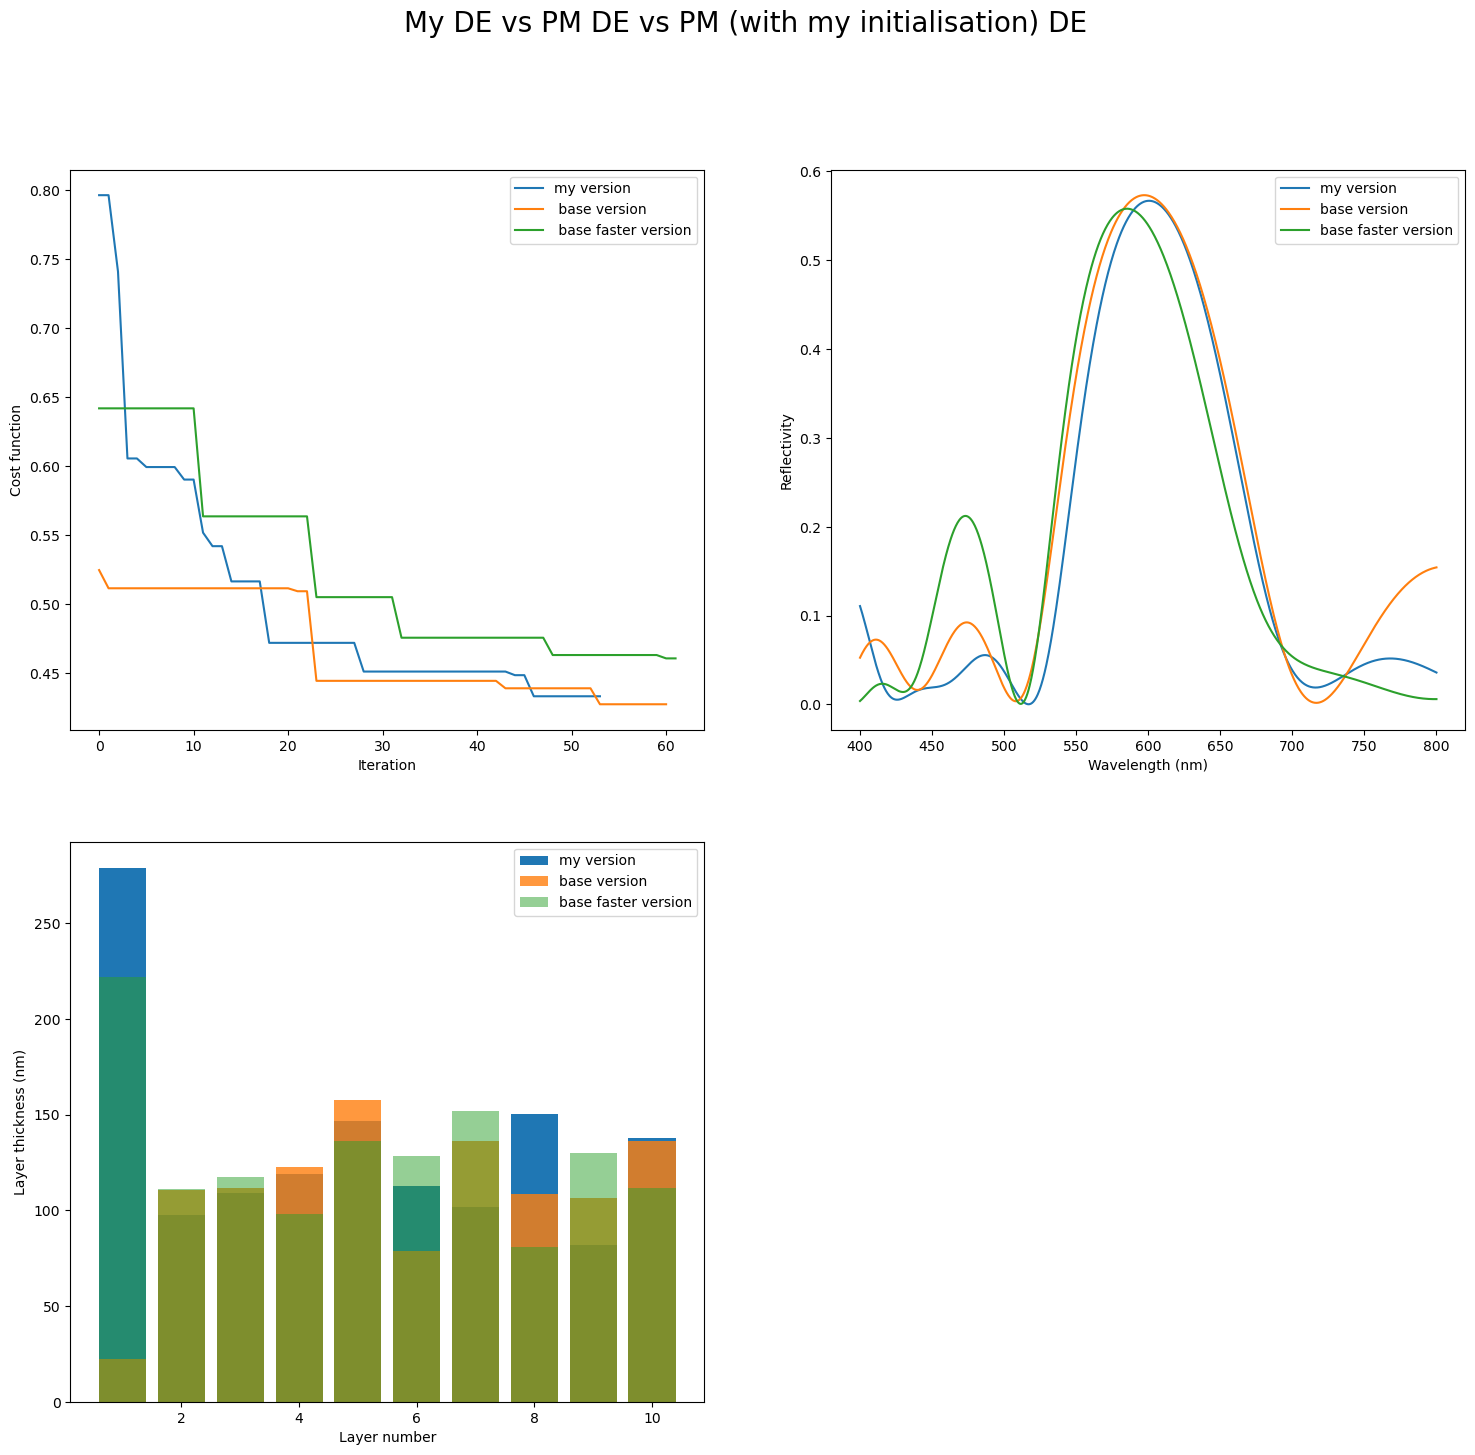

In [28]:
wav_beg = 400
wav_end = 800
nb_wav = 1000
my_reflectivity = np.zeros(nb_wav)
reflectivity = np.zeros(nb_wav)
reflectivity_faster = np.zeros(nb_wav)
wav_list = np.linspace(wav_beg, wav_end, nb_wav)
mat = [1, 1.5, 2]
stack = [0] + [1, 2] * (nb_layers//2) + [0]
my_thickness = [0] + [t for t in my_best_omega] + [0]
my_structure = PM.Structure(mat, stack, my_thickness, verbose=False)
thickness = [0] + [t for t in best] + [0]
structure = PM.Structure(mat, stack, thickness, verbose=False)
thickness_faster = [0] + [t for t in best_faster] + [0]
structure_faster = PM.Structure(mat, stack, thickness_faster, verbose=False)
for i, wav in enumerate(wav_list):
    my_r, my_t, my_R, my_T = PM.coefficient(my_structure, wav, angle, polar)
    my_reflectivity[i] = my_R
    r, t, R, T = PM.coefficient(structure, wav, angle, polar)
    reflectivity[i] = R
    r_faster, t_faster, R_faster, T_faster = PM.coefficient(structure_faster, wav, angle, polar)
    reflectivity_faster[i] = R_faster

plt.figure(figsize=(18,16))
plt.suptitle("My DE vs PM DE vs PM (with my initialisation) DE",fontsize=20)
plt.subplot(2,2,1)
plt.plot(my_convergence, label="my version")
plt.plot(convergence, label=" base version")
plt.plot(convergence_faster, label=" base faster version")
plt.xlabel("Iteration")
plt.ylabel("Cost function")
plt.legend()

plt.subplot(2,2,2)
plt.plot(wav_list, my_reflectivity, label="my version")
plt.plot(wav_list, reflectivity, label="base version")
plt.plot(wav_list, reflectivity_faster, label="base faster version")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectivity")
plt.legend()

plt.subplot(2,2,3)
plt.bar(np.arange(1,nb_layers+1),my_best_omega, label="my version")
plt.bar(np.arange(1,nb_layers+1),best, label="base version", alpha=0.8)
plt.bar(np.arange(1,nb_layers+1),best_faster, label="base faster version", alpha=0.5)
plt.xlabel("Layer number")
plt.ylabel("Layer thickness (nm)")
plt.legend();

This isn't very good, isn't it? (I cannot be sure because the algorithm is not fully deterministic, but there is a very low probability that you had a satisfying result).

This is because the budget was much too low for the objective it had. Let's crank it up! We should also increase the number of layers if we really want to reach a high reflectivty.

**This could be long, be warned.**

In [ ]:
budget = 15000

nb_layers = 30 # We want a 30-layer Dielectric mirror
min_lay = 10 # No layer thinner than 10 nm
max_lay = 300 # No layer thicker than 800 nm (half the wavelength)

X_min = np.array([min_lay] * nb_layers)
X_max = np.array([max_lay] * nb_layers)

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
best, convergence = PM.differential_evolution(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
best_faster, convergence_faster = PM.variant_ini_differential_evolution(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
my_best_omega, my_convergence, my_evaluations=my_differential_evolution(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

print(my_evaluations)

Execution time: 4.555050 seconds
Execution time: 4.310499 seconds
Execution time: 4.265303 seconds
15016


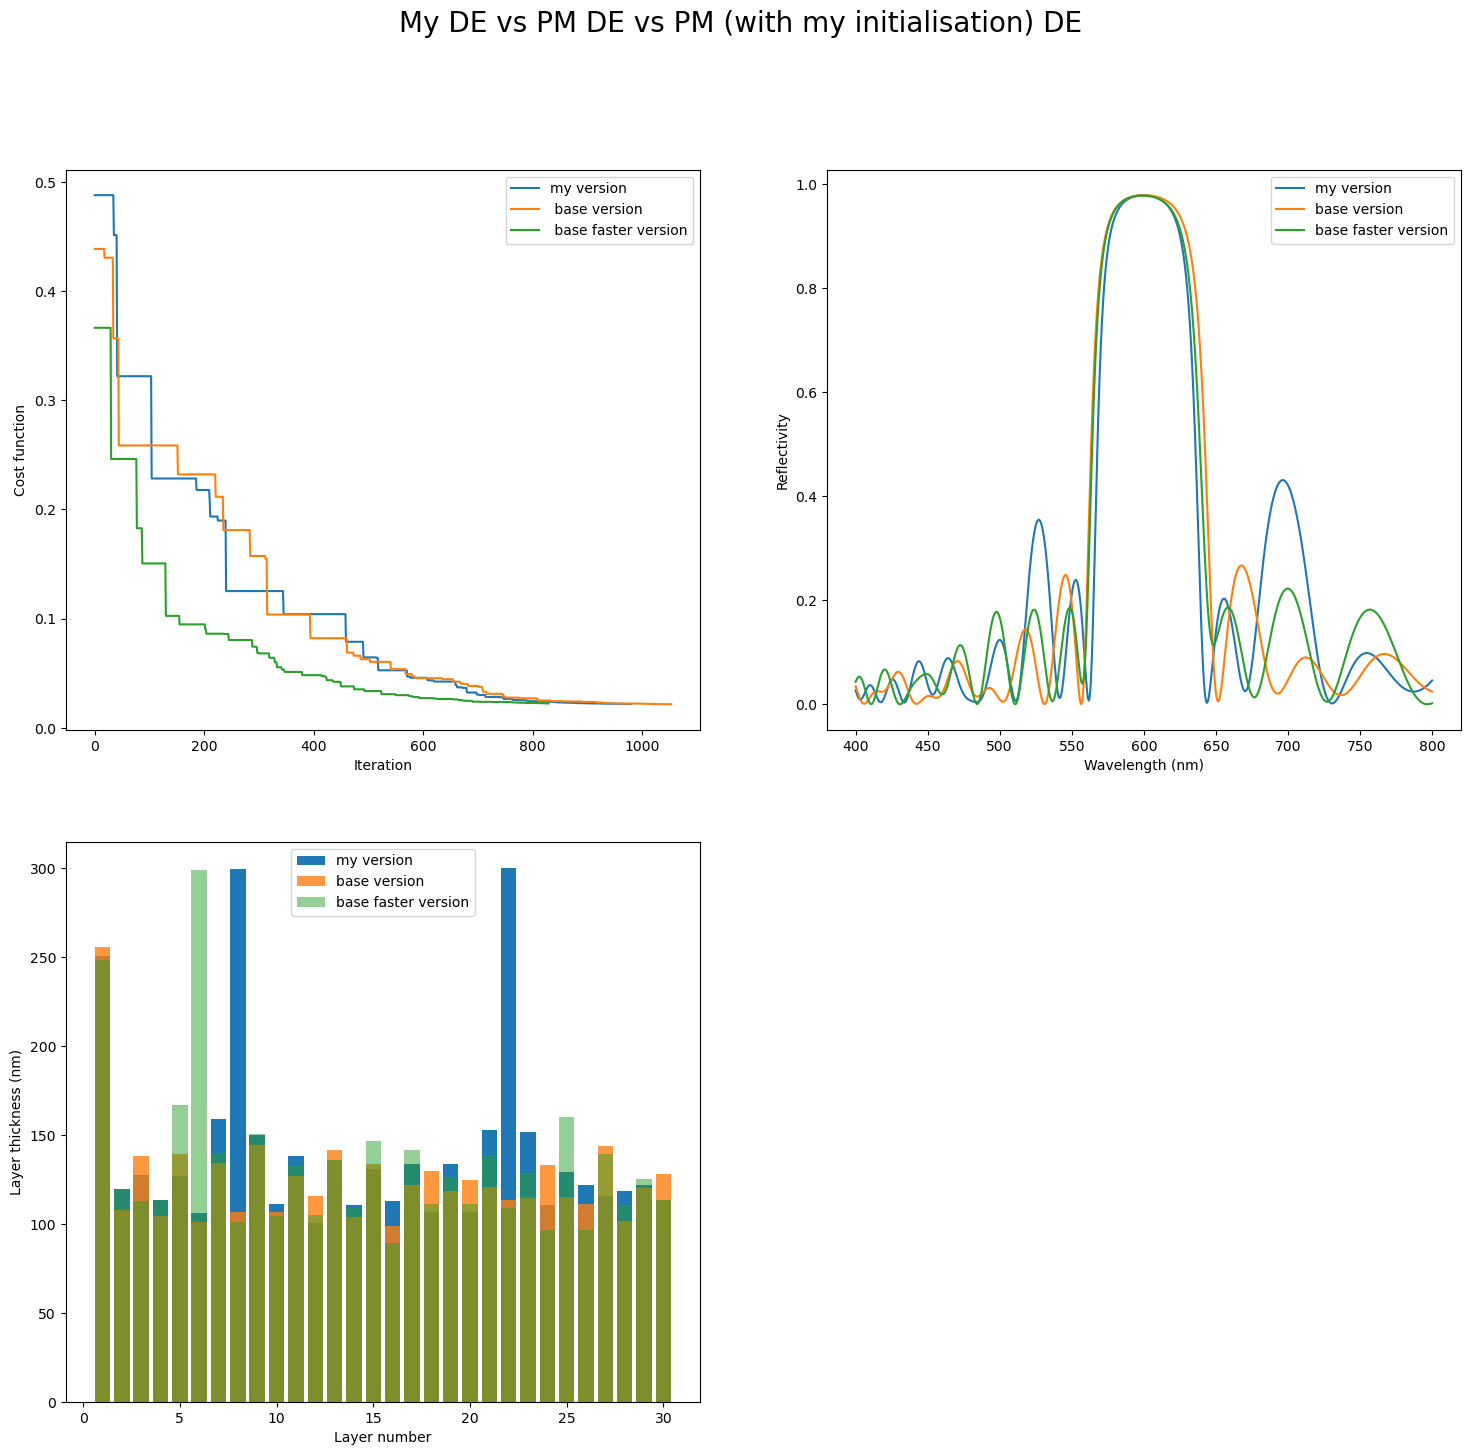

In [8]:
wav_beg = 400
wav_end = 800
nb_wav = 1000
my_reflectivity = np.zeros(nb_wav)
reflectivity = np.zeros(nb_wav)
reflectivity_faster = np.zeros(nb_wav)
wav_list = np.linspace(wav_beg, wav_end, nb_wav)
mat = [1, 1.5, 2]
stack = [0] + [1, 2] * (nb_layers//2) + [0]
my_thickness = [0] + [t for t in my_best_omega] + [0]
my_structure = PM.Structure(mat, stack, my_thickness, verbose=False)
thickness = [0] + [t for t in best] + [0]
structure = PM.Structure(mat, stack, thickness, verbose=False)
thickness_faster = [0] + [t for t in best_faster] + [0]
structure_faster = PM.Structure(mat, stack, thickness_faster, verbose=False)
for i, wav in enumerate(wav_list):
    my_r, my_t, my_R, my_T = PM.coefficient(my_structure, wav, angle, polar)
    my_reflectivity[i] = my_R
    r, t, R, T = PM.coefficient(structure, wav, angle, polar)
    reflectivity[i] = R
    r_faster, t_faster, R_faster, T_faster = PM.coefficient(structure_faster, wav, angle, polar)
    reflectivity_faster[i] = R_faster

plt.figure(figsize=(18,16))
plt.suptitle("My DE vs PM DE vs PM (with my initialisation) DE",fontsize=20)
plt.subplot(2,2,1)
plt.plot(my_convergence, label="my version")
plt.plot(convergence, label=" base version")
plt.plot(convergence_faster, label=" base faster version")
plt.xlabel("Iteration")
plt.ylabel("Cost function")
plt.legend()

plt.subplot(2,2,2)
plt.plot(wav_list, my_reflectivity, label="my version")
plt.plot(wav_list, reflectivity, label="base version")
plt.plot(wav_list, reflectivity_faster, label="base faster version")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectivity")
plt.legend()

plt.subplot(2,2,3)
plt.bar(np.arange(1,nb_layers+1),my_best_omega, label="my version")
plt.bar(np.arange(1,nb_layers+1),best, label="base version", alpha=0.8)
plt.bar(np.arange(1,nb_layers+1),best_faster, label="base faster version", alpha=0.5)
plt.xlabel("Layer number")
plt.ylabel("Layer thickness (nm)")
plt.legend();

## More advanced algorithms

PyMoosh includes other optimization algorithms than DE (more precisely, cur-to-best DE).

First, it includes the 2 variants of DE that have been found to be most reliable for photonics problems:
- `QODE` (Quasi Oppositional) : changes the initialisation to better spread on the whole domain. Takes the same arguments as `differential_evolution`.
- `QNDE` (Quasi Newton DE): the same thing, but ends with a gradient descent for a part of the budget. Takes an additional `bduget_bfgs` argument.

Talking about DE arguments, it is possible to give the mutation `f1`, `f2` and crossover `cr` hyperparameter values as keyword arguments to any of these functions

In [9]:
budget = 15000 #

nb_layers = 30 # We want a 10-layer Dielectric mirror
min_lay = 10 # No layer thinner than 10 nm
max_lay = 300 # No layer thicker than 800 nm (half the largestthe wavelength)

X_min = np.array([min_lay] * nb_layers)
X_max = np.array([max_lay] * nb_layers)

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
best, convergence, evaluations = my_differential_evolution(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
my_best_omega, my_convergence, my_evaluations=my_QO_differential_evolution(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")


Execution time: 4.219647 seconds
Execution time: 4.088021 seconds


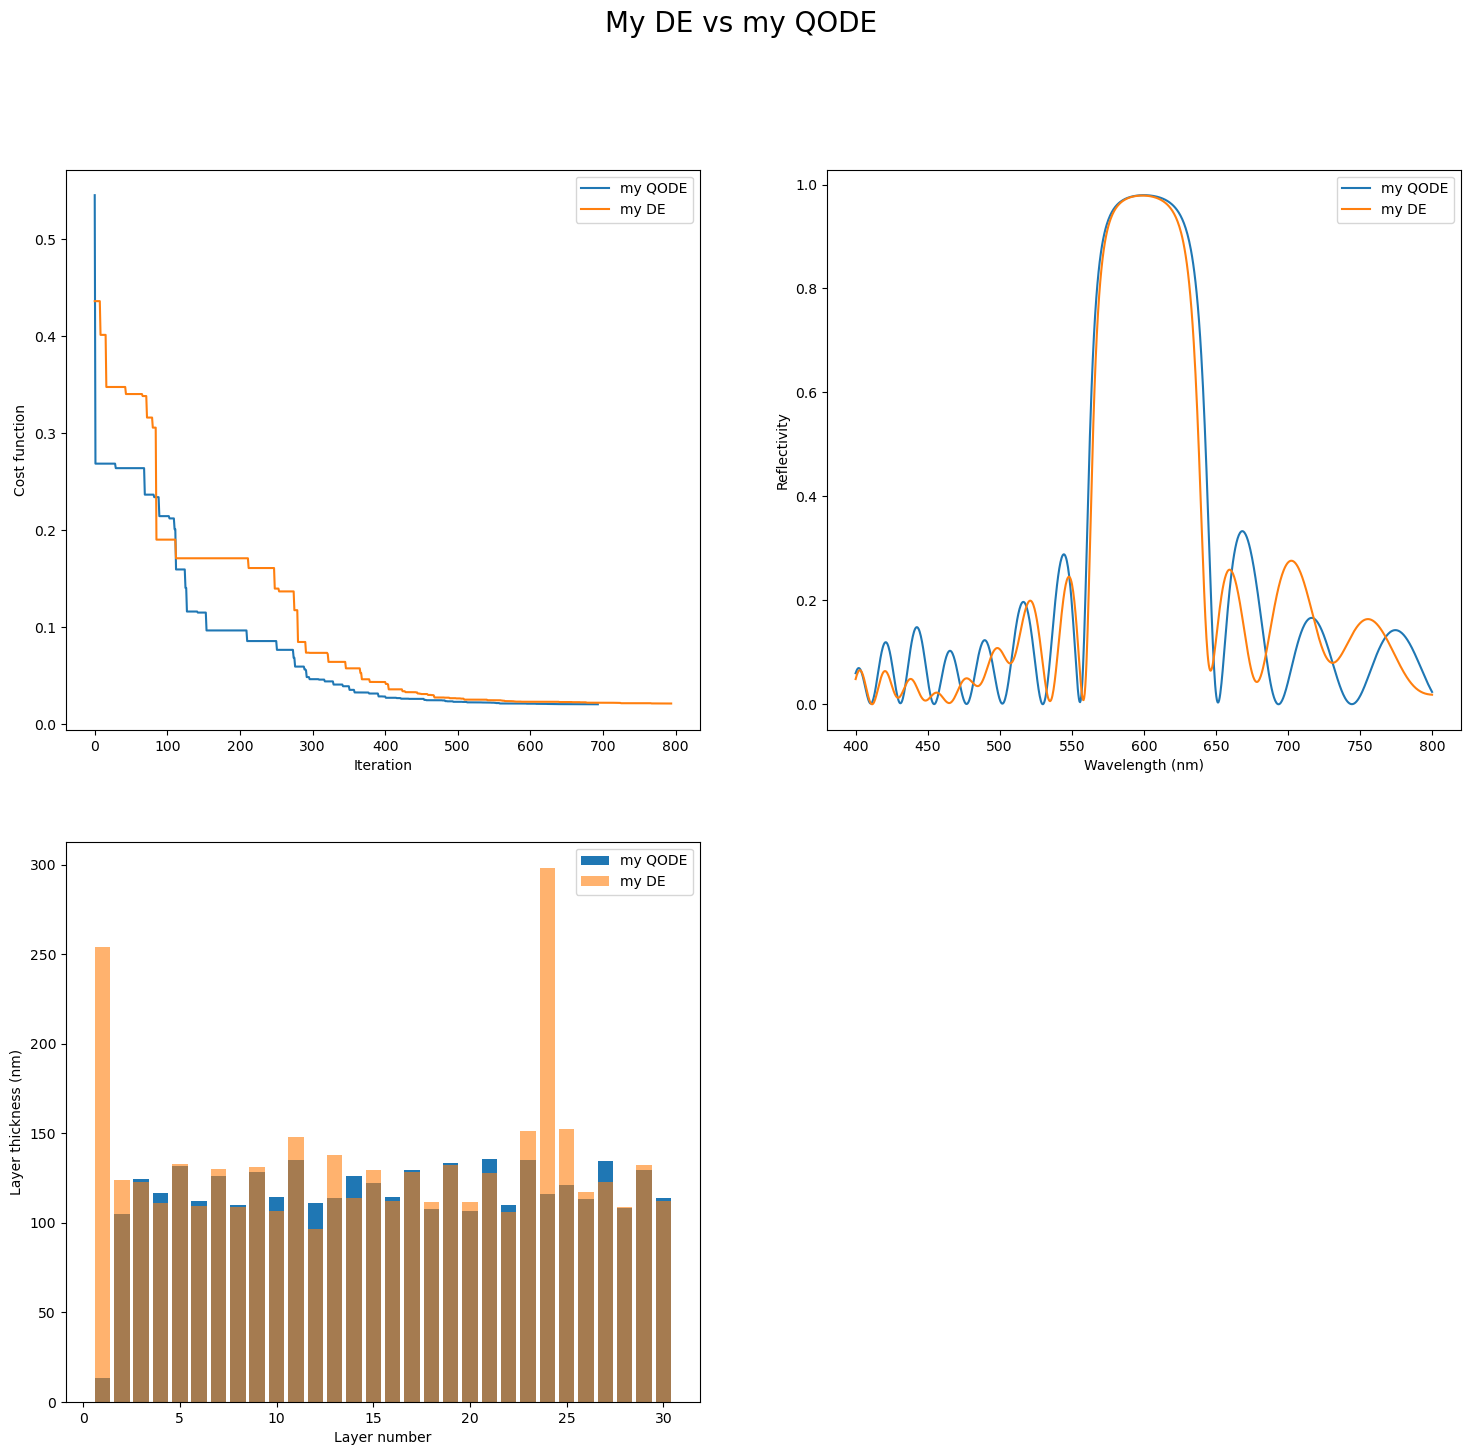

In [10]:
wav_beg = 400
wav_end = 800
nb_wav = 1000
my_reflectivity = np.zeros(nb_wav)
reflectivity = np.zeros(nb_wav)
wav_list = np.linspace(wav_beg, wav_end, nb_wav)
mat = [1, 1.5, 2]
stack = [0] + [1, 2] * (nb_layers//2) + [0]
my_thickness = [0] + [t for t in my_best_omega] + [0]
my_structure = PM.Structure(mat, stack, my_thickness, verbose=False)
thickness = [0] + [t for t in best] + [0]
structure = PM.Structure(mat, stack, thickness, verbose=False)
for i, wav in enumerate(wav_list):
    my_r, my_t, my_R, my_T = PM.coefficient(my_structure, wav, angle, polar)
    my_reflectivity[i] = my_R
    r, t, R, T = PM.coefficient(structure, wav, angle, polar)
    reflectivity[i] = R

plt.figure(figsize=(18,16))
plt.suptitle("My DE vs my QODE",fontsize=20)
plt.subplot(2,2,1)
plt.plot(my_convergence, label="my QODE")
plt.plot(convergence, label="my DE")
plt.xlabel("Iteration")
plt.ylabel("Cost function")
plt.legend()

plt.subplot(2,2,2)
plt.plot(wav_list, my_reflectivity, label="my QODE")
plt.plot(wav_list, reflectivity, label="my DE")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectivity")
plt.legend()

plt.subplot(2,2,3)
plt.bar(np.arange(1,nb_layers+1),my_best_omega, label="my QODE")
plt.bar(np.arange(1,nb_layers+1),best, label="my DE", alpha=0.6)
plt.xlabel("Layer number")
plt.ylabel("Layer thickness (nm)")
plt.legend();

In [ ]:
budget = 15000

nb_layers = 30 # We want a 30-layer Dielectric mirror
min_lay = 10 # No layer thinner than 10 nm
max_lay = 300 # No layer thicker than 800 nm (half the wavelength)

X_min = np.array([min_lay] * nb_layers)
X_max = np.array([max_lay] * nb_layers)

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
best, convergence = PM.differential_evolution(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
best_QO, convergence_QO = PM.QODE(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
best_QO_faster, convergence_QO_faster = PM.variant_ini_QODE(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
best_QN, convergence_QN = PM.QNDE(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

start = time.perf_counter()  # More precise than time.time()
# Your single line of code
my_best_omega, my_convergence, my_evaluations=my_QO_differential_evolution(objective_function, budget, X_min, X_max)
end = time.perf_counter()
print(f"Execution time: {end - start:.6f} seconds")

Execution time: 4.350631 seconds
Execution time: 4.178419 seconds
Execution time: 4.206904 seconds
Execution time: 5.358227 seconds
Execution time: 4.043073 seconds


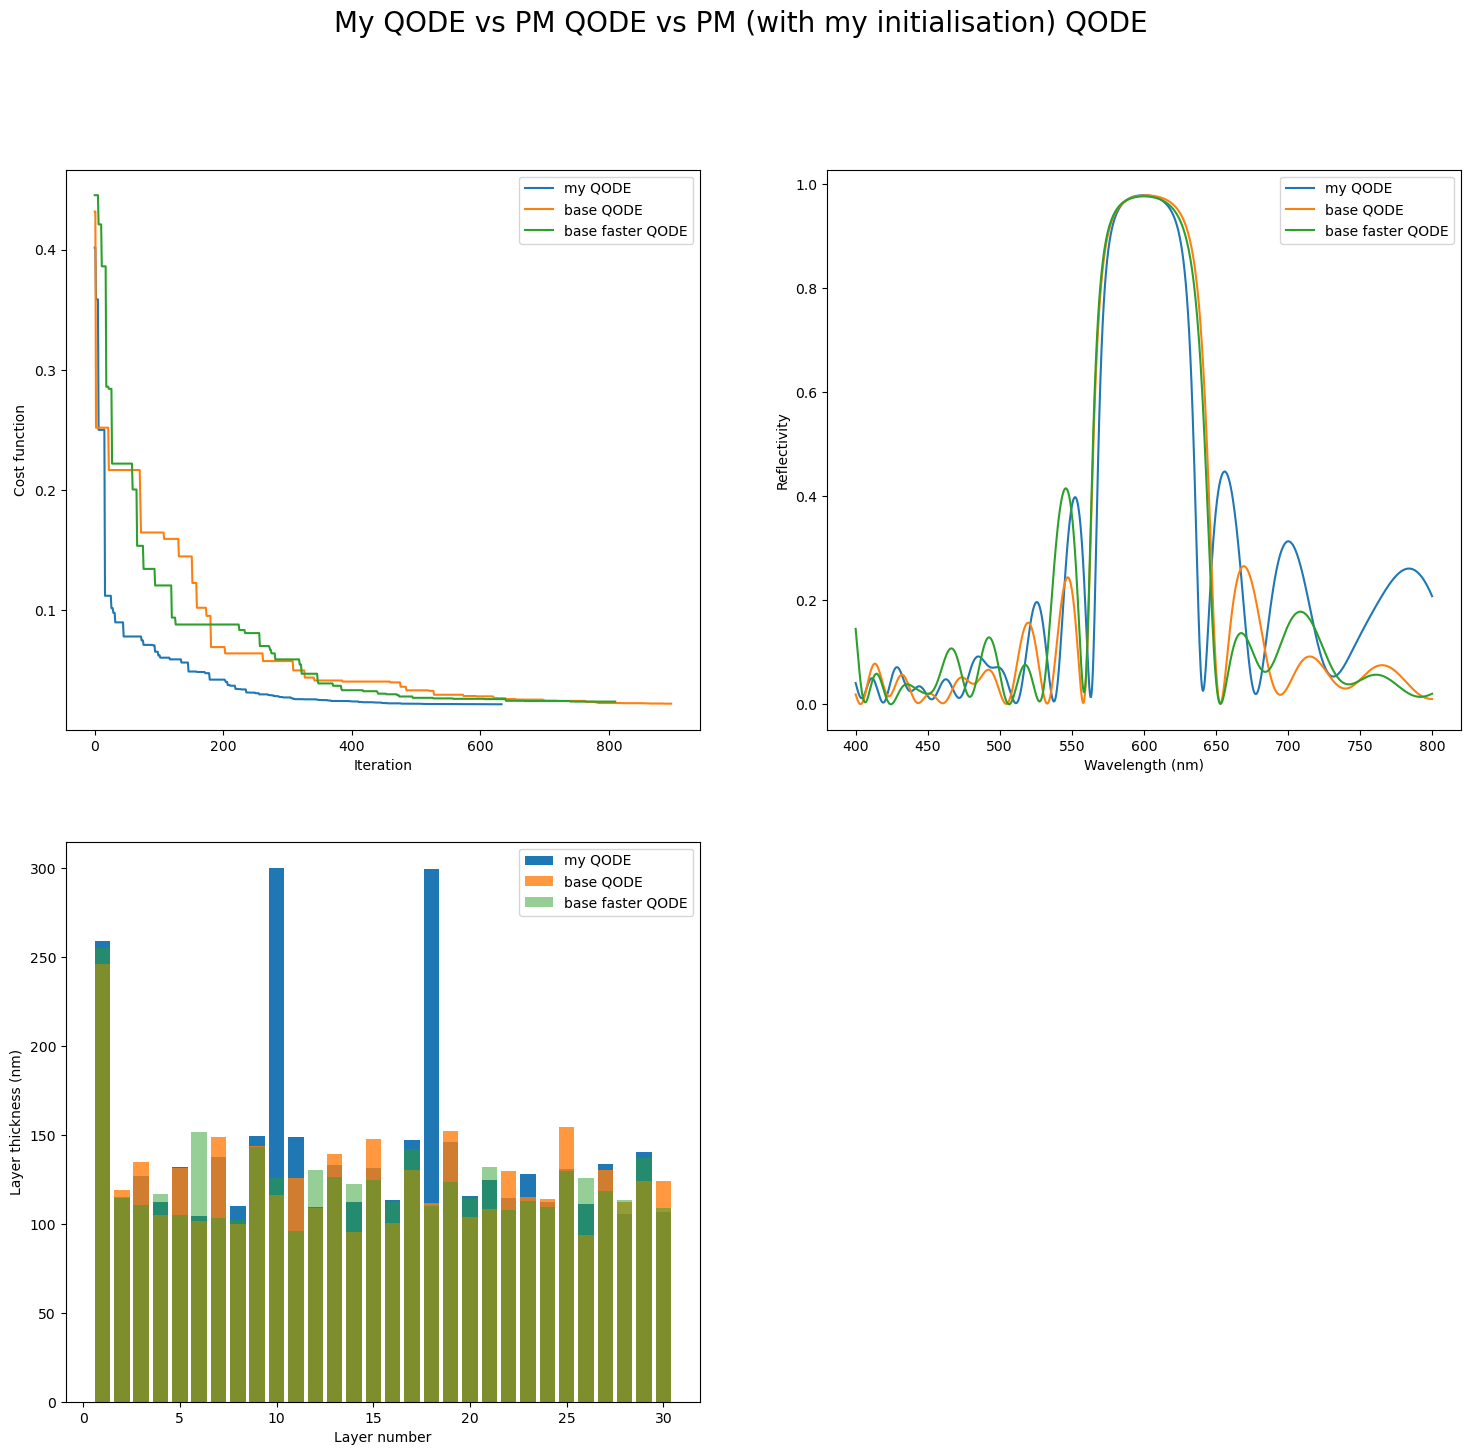

In [12]:
wav_beg = 400
wav_end = 800
nb_wav = 1000
my_reflectivity = np.zeros(nb_wav)
reflectivity_QO = np.zeros(nb_wav)
reflectivity_QO_faster = np.zeros(nb_wav)
wav_list = np.linspace(wav_beg, wav_end, nb_wav)
mat = [1, 1.5, 2]
stack = [0] + [1, 2] * (nb_layers//2) + [0]
my_thickness = [0] + [t for t in my_best_omega] + [0]
my_structure = PM.Structure(mat, stack, my_thickness, verbose=False)
thickness_QO = [0] + [t for t in best_QO] + [0]
structure_QO = PM.Structure(mat, stack, thickness_QO, verbose=False)
thickness_QO_faster = [0] + [t for t in best_QO_faster] + [0]
structure_QO_faster = PM.Structure(mat, stack, thickness_QO_faster, verbose=False)
for i, wav in enumerate(wav_list):
    my_r, my_t, my_R, my_T = PM.coefficient(my_structure, wav, angle, polar)
    my_reflectivity[i] = my_R
    r, t, R, T = PM.coefficient(structure_QO, wav, angle, polar)
    reflectivity_QO[i] = R
    r_faster, t_faster, R_faster, T_faster = PM.coefficient(structure_QO_faster, wav, angle, polar)
    reflectivity_QO_faster[i] = R_faster

plt.figure(figsize=(18,16))
plt.suptitle("My QODE vs PM QODE vs PM (with my initialisation) QODE",fontsize=20)
plt.subplot(2,2,1)
plt.plot(my_convergence, label="my QODE")
plt.plot(convergence_QO, label="base QODE")
plt.plot(convergence_QO_faster, label="base faster QODE")
plt.xlabel("Iteration")
plt.ylabel("Cost function")
plt.legend()

plt.subplot(2,2,2)
plt.plot(wav_list, my_reflectivity, label="my QODE")
plt.plot(wav_list, reflectivity_QO, label="base QODE")
plt.plot(wav_list, reflectivity_QO_faster, label="base faster QODE")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectivity")
plt.legend()

plt.subplot(2,2,3)
plt.bar(np.arange(1,nb_layers+1),my_best_omega, label="my QODE")
plt.bar(np.arange(1,nb_layers+1),best_QO, label="base QODE", alpha=0.8)
plt.bar(np.arange(1,nb_layers+1),best_QO_faster, label="base faster QODE", alpha=0.5)
plt.xlabel("Layer number")
plt.ylabel("Layer thickness (nm)")
plt.legend();

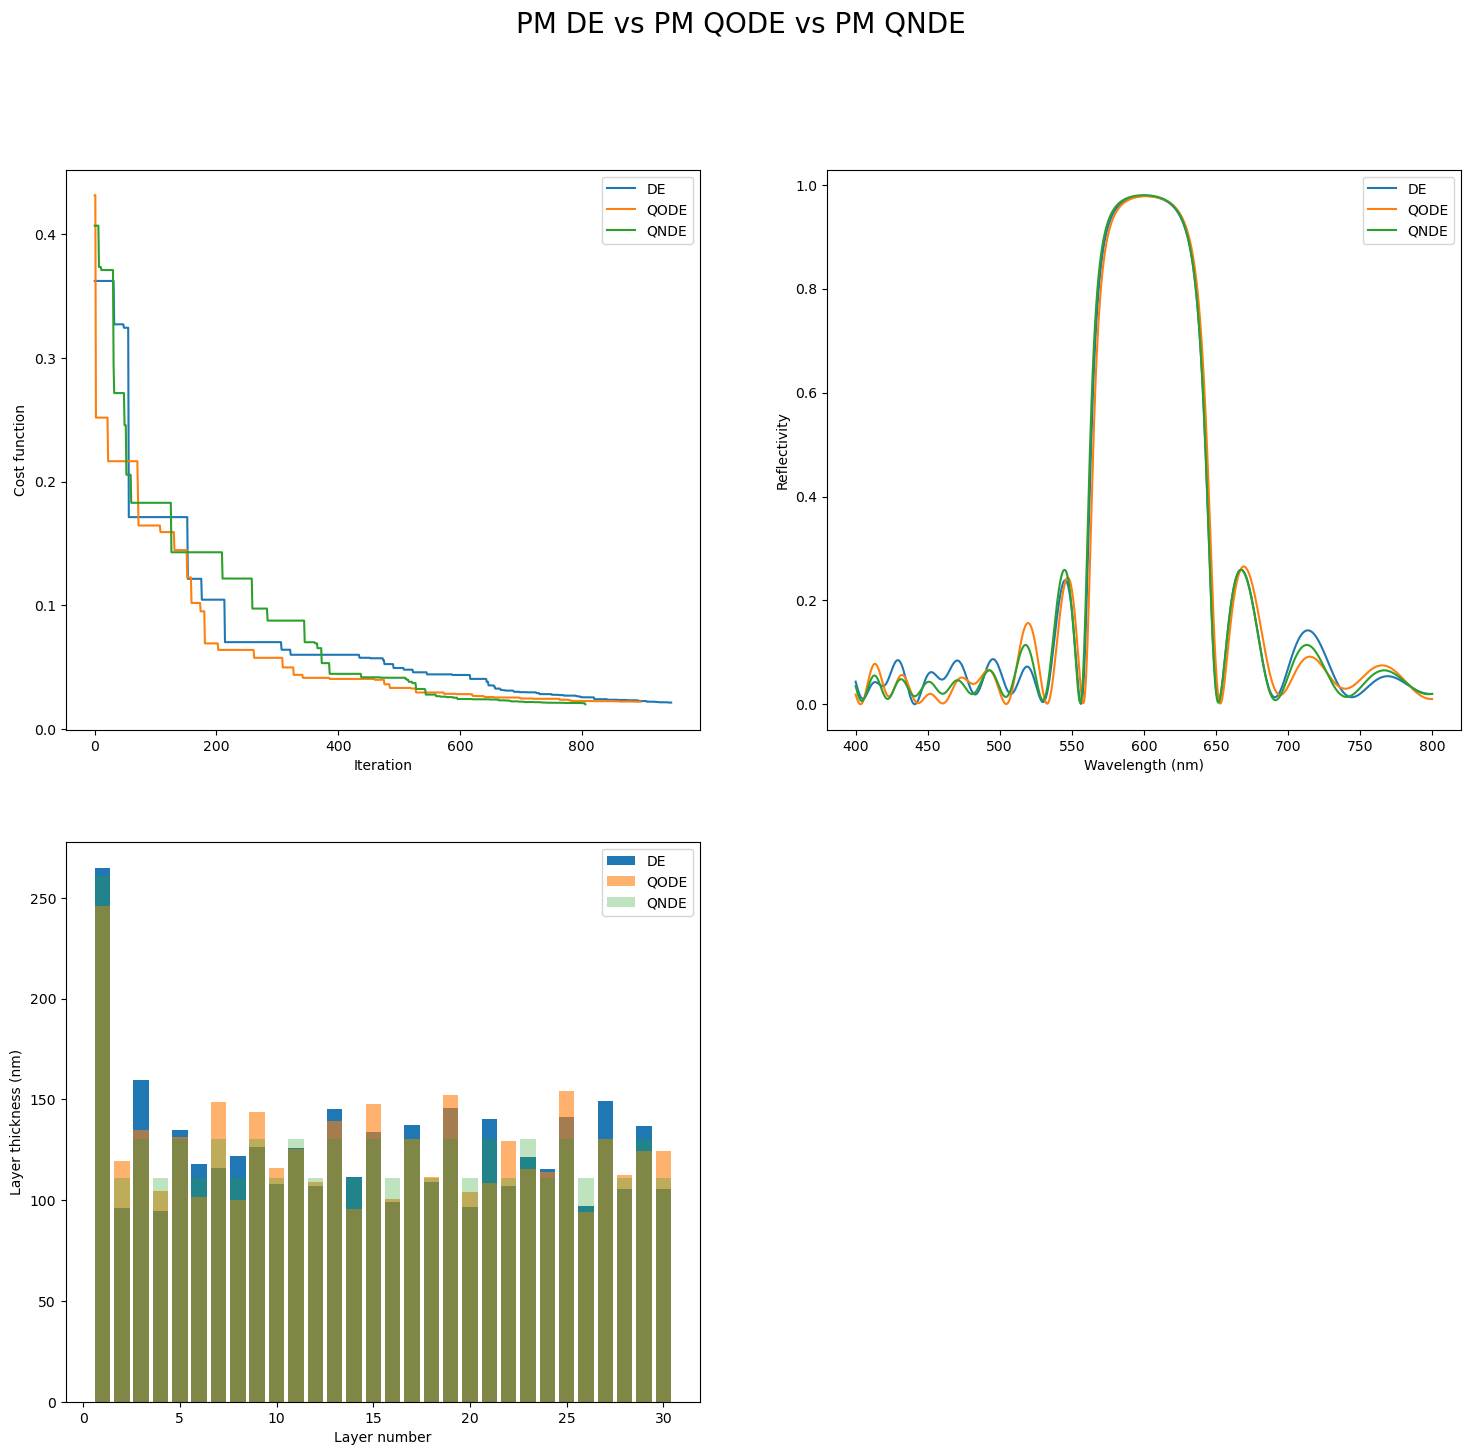

In [13]:
wav_beg = 400
wav_end = 800
nb_wav = 1000
reflectivity = np.zeros(nb_wav)
reflectivity_QO = np.zeros(nb_wav)
reflectivity_QN = np.zeros(nb_wav)
wav_list = np.linspace(wav_beg, wav_end, nb_wav)
mat = [1, 1.5, 2]
stack = [0] + [1, 2] * (nb_layers//2) + [0]
thickness = [0] + [t for t in best] + [0]
structure = PM.Structure(mat, stack, thickness, verbose=False)
thickness_QO = [0] + [t for t in best_QO] + [0]
structure_QO = PM.Structure(mat, stack, thickness_QO, verbose=False)
thickness_QN = [0] + [t for t in best_QN] + [0]
structure_QN = PM.Structure(mat, stack, thickness_QN, verbose=False)
for i, wav in enumerate(wav_list):
    r, t, R, T = PM.coefficient(structure, wav, angle, polar)
    reflectivity[i] = R
    r_QO, t_QO, R_QO, T_QO = PM.coefficient(structure_QO, wav, angle, polar)
    reflectivity_QO[i] = R_QO
    r_QN, t_QN, R_QN, T_QN = PM.coefficient(structure_QN, wav, angle, polar)
    reflectivity_QN[i] = R_QN

plt.figure(figsize=(18,16))
plt.suptitle("PM DE vs PM QODE vs PM QNDE",fontsize=20)
plt.subplot(2,2,1)
plt.plot(convergence, label="DE")
plt.plot(convergence_QO, label="QODE")
plt.plot(convergence_QN, label="QNDE")
plt.xlabel("Iteration")
plt.ylabel("Cost function")
plt.legend()

plt.subplot(2,2,2)
plt.plot(wav_list, reflectivity, label="DE")
plt.plot(wav_list, reflectivity_QO, label="QODE")
plt.plot(wav_list, reflectivity_QN, label="QNDE")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectivity")
plt.legend()

plt.subplot(2,2,3)
plt.bar(np.arange(1,nb_layers+1),best, label="DE")
plt.bar(np.arange(1,nb_layers+1),best_QO, label="QODE", alpha=0.6)
plt.bar(np.arange(1,nb_layers+1),best_QN, label="QNDE", alpha=0.3)
plt.xlabel("Layer number")
plt.ylabel("Layer thickness (nm)")
plt.legend();

# Execution time measurement and comparison among algorithms versions

In [ ]:
min_lay = 10 # No layer thinner than 10 nm
max_lay = 300 # No layer thicker than 800 nm (half the wavelength)

mean_time_PM_DE = []
std_dev_PM_DE = []
mean_time_PM_QODE = []
std_dev_PM_QODE = []
mean_time_fast_DE = []
std_dev_fast_DE = []
mean_time_fast_QODE = []
std_dev_fast_QODE = []

list_nb_layers=[10,20,30,40,50,60,70,80,90,100]

for nb_layers in list_nb_layers:
    print(nb_layers)
    budget = nb_layers*500# to be equivalent to the 30 layers and 15000 of budget config
    X_min = np.array([min_lay] * nb_layers)
    X_max = np.array([max_lay] * nb_layers)

    timer_PM_DE = timeit.Timer(lambda: PM.differential_evolution(objective_function, budget, X_min, X_max))
    timer_PM_QODE = timeit.Timer(lambda: PM.QODE(objective_function, budget, X_min, X_max))
    timer_fast_DE = timeit.Timer(lambda: PM.variant_ini_differential_evolution(objective_function, budget, X_min, X_max))
    timer_fast_QODE = timeit.Timer(lambda: PM.variant_ini_QODE(objective_function, budget, X_min, X_max))

    # Run multiple times
    num_runs = 10
    times_PM_DE = timer_PM_DE.repeat(repeat=num_runs, number=1)  # `repeat` controls how many times we measure
    times_PM_QODE = timer_PM_QODE.repeat(repeat=num_runs, number=1)
    times_fast_DE = timer_fast_DE.repeat(repeat=num_runs, number=1)
    times_fast_QODE = timer_fast_QODE.repeat(repeat=num_runs, number=1)

    # Compute statistics
    mean_time_PM_DE.append(np.mean(times_PM_DE))
    std_dev_PM_DE.append(np.std(times_PM_DE, ddof=1))  # Unbiased standard deviation (Bessel’s correction)
    mean_time_PM_QODE.append(np.mean(times_PM_QODE))
    std_dev_PM_QODE.append(np.std(times_PM_QODE, ddof=1))
    mean_time_fast_DE.append(np.mean(times_fast_DE))
    std_dev_fast_DE.append(np.std(times_fast_DE, ddof=1))
    mean_time_fast_QODE.append(np.mean(times_fast_QODE))
    std_dev_fast_QODE.append(np.std(times_fast_QODE, ddof=1))


10
20
30
40
50
60
70
80
90
100


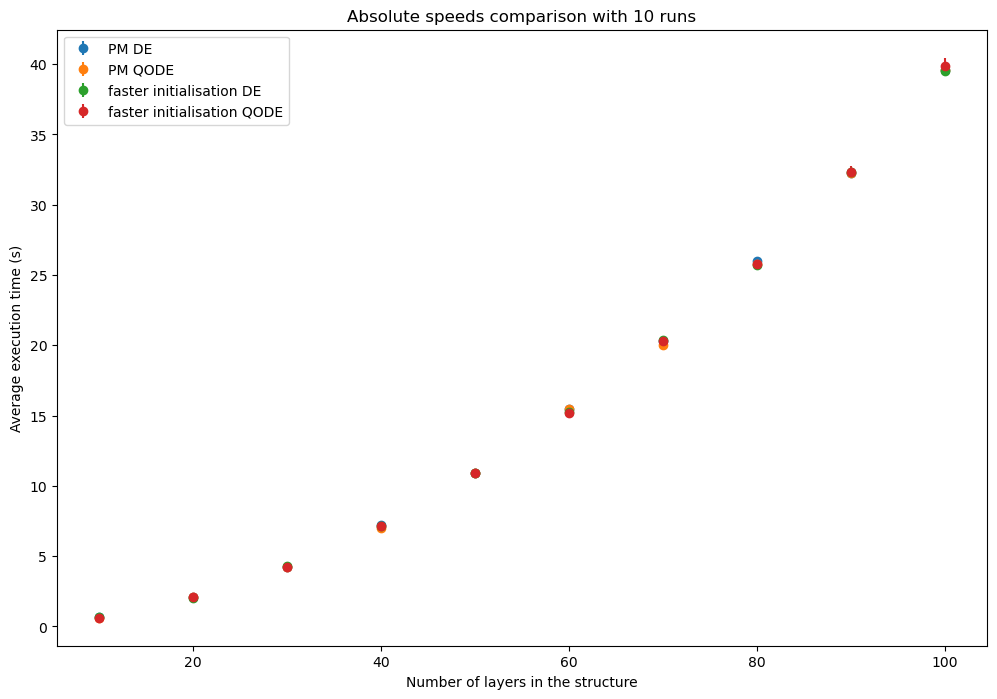

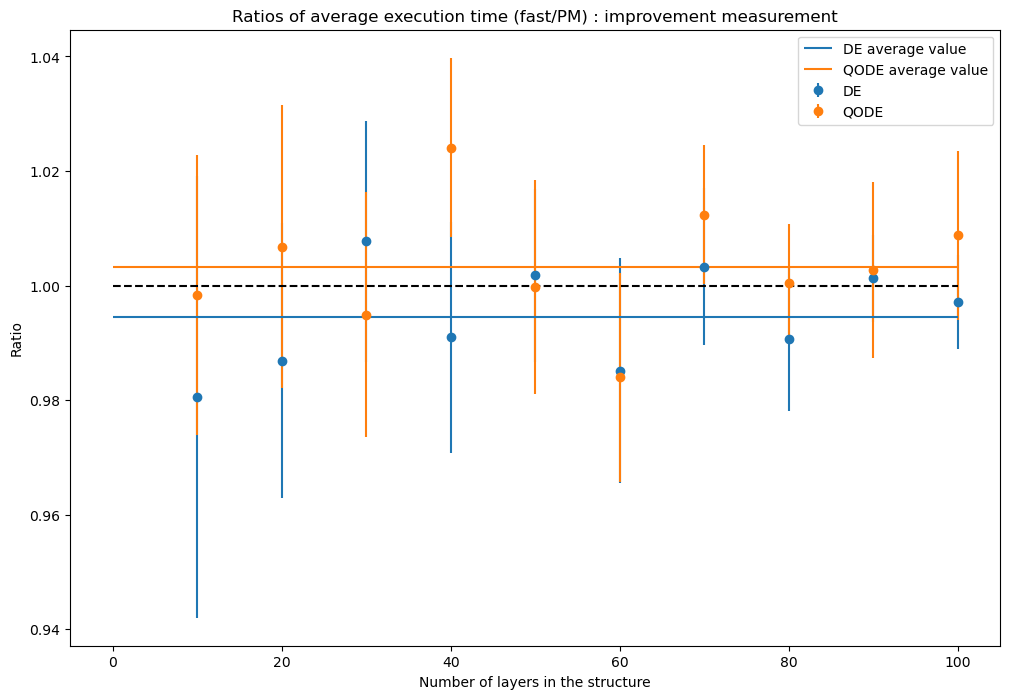

In [52]:
plt.figure(figsize=(12,8))
plt.errorbar(x=list_nb_layers, y=np.array(mean_time_PM_DE), yerr=np.array(std_dev_PM_DE),fmt="o",label="PM DE")
plt.errorbar(x=list_nb_layers, y=np.array(mean_time_PM_QODE), yerr=np.array(std_dev_PM_QODE),fmt="o", label="PM QODE")
plt.errorbar(x=list_nb_layers, y=np.array(mean_time_fast_DE), yerr=np.array(std_dev_fast_DE),fmt="o",label="faster initialisation DE")
plt.errorbar(x=list_nb_layers, y=np.array(mean_time_fast_QODE), yerr=np.array(std_dev_fast_QODE),fmt="o", label="faster initialisation QODE")
plt.xlabel("Number of layers in the structure")
plt.ylabel("Average execution time (s)")
plt.title(f"Absolute speeds comparison with {num_runs} runs")
plt.legend();

# ratios determination to visualise the time improvement with uncertainties propagated properly
mean_time_ratio_DE=np.array(mean_time_fast_DE)/np.array(mean_time_PM_DE)
mean_time_ratio_QODE=np.array(mean_time_fast_QODE)/np.array(mean_time_PM_QODE)
err_ratio_DE=mean_time_ratio_DE*np.sqrt((np.array(std_dev_fast_DE)/np.array(mean_time_fast_DE))**2+(np.array(std_dev_PM_DE)/np.array(mean_time_PM_DE))**2)
err_ratio_QODE=mean_time_ratio_QODE*np.sqrt((np.array(std_dev_fast_QODE)/np.array(mean_time_fast_QODE))**2+(np.array(std_dev_PM_QODE)/np.array(mean_time_PM_QODE))**2)

plt.figure(figsize=(12,8))
plt.errorbar(x=list_nb_layers, y=mean_time_ratio_DE, yerr=err_ratio_DE,fmt="o",label="DE")
plt.errorbar(x=list_nb_layers, y=mean_time_ratio_QODE, yerr=err_ratio_QODE,fmt="o", label="QODE")
plt.xlabel("Number of layers in the structure")
plt.ylabel("Ratio")
plt.title("Ratios of average execution time (fast/PM) : improvement measurement")
plt.hlines(1,0,100,linestyles="--",color="black")
plt.hlines(np.mean(mean_time_ratio_DE),0,100,color="#1f77b4",label="DE average value")
plt.hlines(np.mean(mean_time_ratio_QODE),0,100,color="#ff7f0e",label="QODE average value")
plt.legend();

The plots show no real/noticeable improvements in term of execution time with my initialisation version (less operations in loop).